# **Loading MovieLens Dataset**
### Link : https://www.kaggle.com/datasets/shubhammehta21/movie-lens-small-latest-dataset

In [1]:
import pandas as pd
ratings = pd.read_csv('/kaggle/input/movie-lens-small-latest-dataset/ratings.csv', usecols=['userId', 'movieId', 'rating', 'timestamp'])
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [2]:
#The number of unique users and movies
n_users = ratings.userId.unique().shape[0]
n_movies = ratings.movieId.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))

Number of users = 610 | Number of movies = 9724


# **Singular Value Decomposition (SVD)**

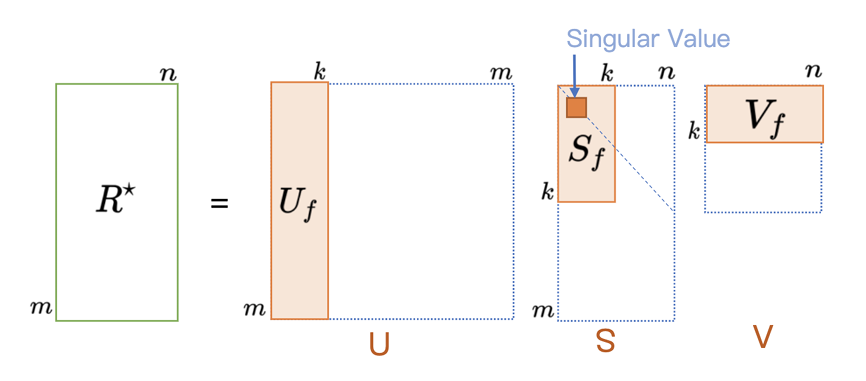

In [3]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

In [4]:
# Create a user-item rating matrix where rows are users, columns are movies, and values are ratings
train_matrix = train_data.pivot(index='userId', columns='movieId', values='rating')

In [5]:
# Fill missing ratings with the user's average rating
user_mean = train_matrix.mean(axis=1)
train_matrix_filled = train_matrix.apply(lambda row: row.fillna(row.mean()), axis=1)

In [6]:
import numpy as np

#Convert the filled training matrix into a numpy array
R = train_matrix_filled.values
# Calculate the mean rating for each user to demean the ratings
user_ratings_mean = np.mean(R, axis=1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

In [7]:
# Perform Singular Value Decomposition (SVD) on the demeaned matrix

from scipy.sparse.linalg import svds
U, sigma, Vt = np.linalg.svd(R_demeaned, full_matrices=False)

In [8]:
# Convert sigma to a diagonal matrix
sigma = np.diag(sigma)
# Reconstruct the predicted ratings by multiplying U, sigma, and Vt, then add the user mean
predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
# Convert the predicted ratings matrix to a DataFrame for easy access
preds_df = pd.DataFrame(predicted_ratings, index=train_matrix.index, columns=train_matrix.columns)

In [9]:
# Prepare the test data for evaluation
test_data = test_data.copy()
# For each row in the test data, get the predicted rating from the predictions DataFrame
# If the movie or user does not exist in the predictions, use the user's mean rating
test_data['predicted_rating'] = test_data.apply(lambda row: preds_df.loc[row['userId'], row['movieId']] if (row['userId'] in preds_df.index and row['movieId'] in preds_df.columns) else user_mean.get(row['userId'], 3.0), axis=1)

In [10]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score


# RMSE
rmse = sqrt(mean_squared_error(test_data['rating'], test_data['predicted_rating']))

# MAE
mae = mean_absolute_error(test_data['rating'], test_data['predicted_rating'])


# Assume a rating is considered positive (liked) if it's >= threshold
threshold = 3.5

# Create binary columns: 1 if the rating is greater than or equal to the threshold, else 0
test_data['actual_positive'] = test_data['rating'] >= threshold
test_data['predicted_positive'] = test_data['predicted_rating'] >= threshold

# Precision and Recall
precision = precision_score(test_data['actual_positive'], test_data['predicted_positive'])
recall = recall_score(test_data['actual_positive'], test_data['predicted_positive'])

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

MAE: 0.7386
RMSE: 0.9497
Precision: 0.7551
Recall: 0.6304


# **FunkSVD**

In [11]:
!pip install numpy==1.24.4
!pip install scikit-surprise

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 83.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.15.3 which is incompatible.
mkl-umath 0.1.1 requires numpy<1.27.0,>=1.26.4, but you have numpy 1.24.4 which is incompatible.
mkl-random 1.2.4 requires numpy<1.27.0,>=1.26.4, but you have numpy 1.24.4 which is incompatible.
mkl-fft 1.3.8 requires numpy<1.27.0,>=1.26.4, but you have numpy 1.24.4 which is incompatible.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.5.1 which is incompati

In [12]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
# Prepare the dataset for Surprise library
reader = Reader(rating_scale=(1.0, 5.0))  # Define the rating scale
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [13]:
from surprise import SVD

# Create the SVD model
model = SVD(n_factors=50, lr_all=0.005, reg_all=0.02)

# Train the model using the training set
model.fit(trainset)

# Make predictions on the test set
predictions = model.test(testset)

In [14]:
from surprise import accuracy
from sklearn.metrics import precision_score, recall_score


mae = accuracy.mae(predictions, verbose=False)
rmse = accuracy.rmse(predictions, verbose=False)

# Define a threshold to consider a movie as "liked"
threshold = 3.0

# Convert the true and predicted ratings into binary format
y_true = [1 if true_r >= threshold else 0 for true_r in [pred.r_ui for pred in predictions]]
y_pred = [1 if est >= threshold else 0 for est in [pred.est for pred in predictions]]


precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)


print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

MAE: 0.6748
RMSE: 0.8778
Precision: 0.8819
Recall: 0.8877


# **SVD++**

In [15]:
from surprise import SVDpp

algo = SVDpp(n_factors=50, n_epochs=25, lr_all=0.005, reg_all=0.02)

# Train the model using the training set
algo.fit(trainset)

# Make predictions on the test set
predictions = algo.test(testset)

In [16]:
from surprise import accuracy
from sklearn.metrics import precision_score, recall_score


mae = accuracy.mae(predictions, verbose=False)
rmse = accuracy.rmse(predictions, verbose=False)

# Define a threshold to consider a movie as "liked"
threshold = 3.0

# Convert the true and predicted ratings into binary format
y_true = [1 if true_r >= threshold else 0 for true_r in [pred.r_ui for pred in predictions]]
y_pred = [1 if est >= threshold else 0 for est in [pred.est for pred in predictions]]


precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)


print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

MAE: 0.6677
RMSE: 0.8712
Precision: 0.8867
Recall: 0.8777


# **Non-negative Matrix Factorisation (NMF)**

In [17]:
from surprise import NMF
# Create NMF algorithm
nmf = NMF(n_factors=50,
          n_epochs=200,
          reg_pu=0.02,  # regularisation for users
          reg_qi=0.02)  # regularisation for items

# Train the model using the training set
nmf.fit(trainset)

# Make predictions on the test set
predictions = nmf.test(testset)

In [18]:
mae = accuracy.mae(predictions,verbose=False)
rmse = accuracy.rmse(predictions,verbose=False)


threshold = 3.0


y_true = [1 if pred.r_ui >= threshold else 0 for pred in predictions]
y_pred = [1 if pred.est >= threshold else 0 for pred in predictions]


precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)


print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

MAE: 0.7391
RMSE: 0.9725
Precision: 0.8847
Recall: 0.8149


# **Alternating Least Squares (ALS)**

In [19]:
!pip install implicit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 52.9 MB/s eta 0:00:0000:0100:01


In [20]:
import os
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, mean_absolute_error, mean_squared_error, roc_auc_score
import implicit

# Your existing preprocessing code
ratings['userId'] = ratings['userId'] - ratings['userId'].min()
ratings['movieId'] = ratings['movieId'] - ratings['movieId'].min()
ratings['interaction'] = (ratings['rating'] >= 3).astype(int)

trainset, testset = train_test_split(ratings, test_size=0.2, random_state=42)
train_matrix = coo_matrix((trainset['interaction'], (trainset['userId'], trainset['movieId']))).tocsr()

# Model training
model = implicit.als.AlternatingLeastSquares(factors=50, regularization=0.1, iterations=20, dtype=np.float32)
model.fit(train_matrix)

# Method 1: More efficient evaluation using ranking approach
print("=== Method 1: Ranking-based Evaluation ===")
y_true_full = []
y_pred_full = []

# Set N to a reasonable number (e.g., 50, 100, 200)
N_RECOMMENDATIONS = 500  # <-- CHANGE THIS VALUE

for _, row in testset.iterrows():
    user_id = int(row['userId'])
    movie_id = int(row['movieId'])
    true_interaction = int(row['interaction'])

    # Ensure user exists in training data
    if user_id < train_matrix.shape[0]:
        try:
            # Get top N recommendations for this user
            user_items = train_matrix[user_id]
            scores = model.recommend(user_id, user_items, N=N_RECOMMENDATIONS, filter_already_liked_items=False)

            recommended_items = scores[0]
            recommended_scores = scores[1]

            # Check if our specific movie is in the top N recommendations
            if movie_id in recommended_items:
                # Get the score for this movie
                movie_idx = np.where(recommended_items == movie_id)[0][0]
                pred_score = recommended_scores[movie_idx]
                # Normalize score to 0-1 range for thresholding
                pred_binary = 1  # It's in top N, so predict positive
            else:
                # Movie not in top N recommendations
                pred_score = 0.0
                pred_binary = 0  # Not in top N, so predict negative

            y_true_full.append(true_interaction)
            y_pred_full.append(pred_binary)

        except Exception as e:
            continue

if len(y_true_full) > 0:
    precision_full = precision_score(y_true_full, y_pred_full, zero_division=0)
    recall_full = recall_score(y_true_full, y_pred_full, zero_division=0)
    mae_full = mean_absolute_error(y_true_full, y_pred_full)
    rmse_full = np.sqrt(mean_squared_error(y_true_full, y_pred_full))

    print(f"MAE: {mae_full:.4f}")
    print(f"RMSE: {rmse_full:.4f}")
    print(f"Precision: {precision_full:.4f}")
    print(f"Recall: {recall_full:.4f}")
    print(f"Number of test samples: {len(y_true_full)}")
    print(f"Using N={N_RECOMMENDATIONS} recommendations per user")
else:
    print("No valid predictions could be made")

print("\n=== Method 2: Comparing Different N Values ===")
N_values = [10, 25, 50, 100, 200]

for N in N_values:
    print(f"\n--- N = {N} ---")
    y_true_n = []
    y_pred_n = []

    for _, row in testset.iterrows():
        user_id = int(row['userId'])
        movie_id = int(row['movieId'])
        true_interaction = int(row['interaction'])

        if user_id < train_matrix.shape[0]:
            try:
                user_items = train_matrix[user_id]
                scores = model.recommend(user_id, user_items, N=N, filter_already_liked_items=False)

                recommended_items = scores[0]

                # Simple binary prediction: 1 if in top N, 0 otherwise
                pred_binary = 1 if movie_id in recommended_items else 0

                y_true_n.append(true_interaction)
                y_pred_n.append(pred_binary)

            except Exception as e:
                continue

    if len(y_true_n) > 0:
        precision_n = precision_score(y_true_n, y_pred_n, zero_division=0)
        recall_n = recall_score(y_true_n, y_pred_n, zero_division=0)

        print(f"Precision: {precision_n:.4f}")
        print(f"Recall: {recall_n:.4f}")
        print(f"Test samples: {len(y_true_n)}")

/usr/local/lib/python3.11/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: Intel MKL BLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'MKL_NUM_THREADS=1' or by callng 'threadpoolctl.threadpool_limits(1, "blas")'. Having MKL use a threadpool can lead to severe performance issues
  check_blas_config()
/usr/local/lib/python3.11/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/20 [00:00<?, ?it/s]

=== Method 1: Ranking-based Evaluation ===
MAE: 0.5111
RMSE: 0.7149
Precision: 0.8915
Recall: 0.4194
Number of test samples: 20168
Using N=500 recommendations per user

=== Method 2: Comparing Different N Values ===

--- N = 10 ---
Precision: 0.9455
Recall: 0.0149
Test samples: 20168

--- N = 25 ---
Precision: 0.9449
Recall: 0.0504
Test samples: 20168

--- N = 50 ---
Precision: 0.9306
Recall: 0.1061
Test samples: 20168

--- N = 100 ---
Precision: 0.9215
Recall: 0.1783
Test samples: 20168

--- N = 200 ---
Precision: 0.9086
Recall: 0.2731
Test samples: 20168
